In [1]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import pytz
import numpy as np
import os
import sys
import glob
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import re


scripts_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts'))
sys.path.append(scripts_dir)
from data_generator import normalize_new_data

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.set_default_device(device)

cuda


In [3]:
# Define the directory and base filename pattern
file_pattern = "../data/final_data/cleaned_compiled_data_normalized_part*.csv"

# Use glob to get a sorted list of all matching CSV parts
csv_files = sorted(glob.glob(file_pattern))

# Load and concatenate all parts
data = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

# Done! Now `data` holds the full combined normalized DataFrame
print(f"Loaded {len(csv_files)} files. Final shape: {data.shape}")

Loaded 2 files. Final shape: (300282, 37)


In [4]:
chosen_stations = ['S104', 'S107', 'S109', 'S115', 'S116', 'S43', 'S50', 'S24']
pixel_coords = [(4, 11, 'S109'), (2, 7, 'S50'), (1, 16, 'S107'), (2, 13, 'S43'), (0, 0, 'S115'), (0, 6, 'S116'), (8, 8, 'S104')]
def tabular_to_image(data: pd.DataFrame, pixel_coords, image_shape=(9, 18)):
    feature_types = ['rainfall', 'air_temperature', 'wind_speed', 'relative_humidity', 'wind_direction']
    H, W = image_shape
    T = data.shape[0]
    image = np.full((T, H, W, len(feature_types)), np.nan, dtype=np.float32)

    feature_to_channel = {feat: i for i, feat in enumerate(feature_types)}

    for y, x, station_id in pixel_coords:
        for feat in feature_types:
            col_name = f"{feat}_{station_id}"
            if col_name in data.columns:
                channel = feature_to_channel[feat]
                image[:, y, x, channel] = data[col_name].values

    return image if T > 1 else image[0]

In [5]:
class LightningDataset_Modified(Dataset):
    def __init__(self, compiled_df, pixel_coords, image_shape=(9, 18), timezone_str="Asia/Singapore", reject_zeros = True):
        self.compiled_df = compiled_df.copy()
        self.pixel_coords = pixel_coords
        self.image_shape = image_shape
        self.timezone = pytz.timezone(timezone_str)
        self.samples = []
        self.reject_zeros = reject_zeros

        self._prepare_dataset()

    def _prepare_dataset(self):
        # Ensure datetime index
        self.compiled_df["Timestamp"] = pd.to_datetime(self.compiled_df["Timestamp"])
        if not isinstance(self.compiled_df.index, pd.DatetimeIndex):
            self.compiled_df.set_index("Timestamp", inplace=True)
        self.compiled_df.index = self.compiled_df.index.tz_localize(None)

        # Drop target for input features
        input_df = self.compiled_df.drop(columns=["Lightning_Risk"])

        # Valid 2-hour timestamps
        min_ts = self.compiled_df.index.min().ceil("2h") + pd.Timedelta(hours=2)
        max_ts = self.compiled_df.index.max().floor("2h")
        valid_ts = self.compiled_df.loc[
            (self.compiled_df.index >= min_ts) &
            (self.compiled_df.index <= max_ts) &
            (self.compiled_df.index.hour % 2 == 0) &
            (self.compiled_df.index.minute == 0)
        ].index

        for timestamp in valid_ts:
            try:
                # Input time windows (past 5)
                input_times = [timestamp - pd.Timedelta(minutes=delta) for delta in [120, 90, 60, 30, 0]]
                input_slices = self.compiled_df.loc[input_times]
                input_images = tabular_to_image(input_slices, self.pixel_coords, self.image_shape)  # (5, H, W, C)

                # Rearrange to (C, T, H, W) if needed
                input_tensor = np.transpose(input_images, (3, 0, 1, 2))  # (C, T, H, W)

                # Output time windows (future 5)
                output_times = [timestamp + pd.Timedelta(minutes=delta) for delta in [0, 30, 60, 90, 120]]
                output_data = self.compiled_df.loc[output_times, "Lightning_Risk"].astype(int).values.flatten()
                if self.reject_zeros and not (output_data == 1).any():
                    continue 
                self.samples.append((input_tensor, output_data))
            except KeyError:
                continue  # Skip if any timestamps are missing

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        # x: shape (C, T, H, W) → permute to (T, C, H, W) for model
        x = torch.tensor(x, dtype=torch.float32).permute(1, 0, 2, 3)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y
    
    def get_positive_ratio(self):
        all_labels = np.array([sample[1] for sample in self.samples])  # shape (N, 5)
        total = all_labels.size
        positives = (all_labels == 1).sum()
        return positives / total

In [27]:
dataset = LightningDataset_Modified(data,pixel_coords)
g = torch.Generator(device="cuda") if torch.cuda.is_available() else torch.Generator()
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, generator=g)

In [11]:
class LightningRiskCNNGRU(nn.Module):
    def __init__(self, num_channels=5, num_future_steps=5, hidden_size=512):
        super(LightningRiskCNNGRU, self).__init__()  # updated here

        # --- CNN Feature Extractor ---
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()

        # Dynamically determine CNN output size
        with torch.no_grad():
            dummy_input = torch.zeros(1, num_channels, 9, 18)
            x = F.relu(self.conv1(dummy_input))
            x = F.relu(self.conv2(x))
            x = F.relu(self.conv3(x))
            self.feature_size = self.flatten(x).shape[1]

        self.bn_in = nn.BatchNorm1d(self.feature_size)

        # --- GRU ---
        self.gru  = nn.GRU(
            input_size=self.feature_size,
            hidden_size=hidden_size,
            num_layers=2,         # two layers
            dropout=0.3,          # between layers
            batch_first=True,
            bidirectional=True
        )

        # --- Output Layer ---
        self.fc = nn.Linear(hidden_size * 2, num_future_steps)

        # --- Learnable initial hidden state ---
        self.initial_hidden_state = nn.Parameter(torch.randn(4, 1, hidden_size))

    def forward(self, x):
        # x: (batch_size, seq_len=5, channels=5, height, width)
        batch_size, seq_len, c, h, w = x.shape

        cnn_features = []
        for t in range(seq_len):
            x_t = x[:, t]  # (batch, channels, height, width)
            x_t = torch.nan_to_num(x_t, nan=0.0)

            out = F.relu(self.conv1(x_t))
            out = F.relu(self.conv2(out))
            out = F.relu(self.conv3(out))
            out = self.flatten(out)
 
            cnn_features.append(out)

        cnn_features = torch.stack(cnn_features, dim=1)  # (batch_size, seq_len, feature_size)

        # Expand learnable hidden state for batch
        h0 = self.initial_hidden_state.expand(4, batch_size, -1).contiguous()

        # cnn_features: (B, T, F)
        B, T, Fe = cnn_features.shape
        
        # merge batch+time → apply BN across F
        feat = cnn_features.view(B * T, Fe)        # → (B*T, Fe)
        feat = self.bn_in(feat)                    # batch‑norm over Fe
        feat = feat.view(B, T, Fe)                  # → (B, T, Fe)
        
        # GRU
        gru_out, _ = self.gru(feat, h0)
        
        # Final hidden state
        final_hidden = gru_out[:, -1, :]  # (batch_size, hidden_size)

        # Risk prediction (sigmoid for binary/multi-label classification)
        predictions = torch.sigmoid(self.fc(final_hidden))  # (batch_size, num_future_steps)

        return predictions


In [12]:
model = LightningRiskCNNGRU().to(device)
# Get one batch
for batch_x, batch_y in dataloader:
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

In [28]:
def train(dataloader, model, num_epochs, learning_rate, device=device):
    model.train()
    model.to(device)  # Ensure model is on GPU/CPU

    # Binary Cross Entropy Loss for multi-label binary outputs
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # List to track the average loss for every epoch (including epoch 0)
    avg_loss_history = []

    os.makedirs("models", exist_ok=True)  # Ensure the directory exists
    timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M')
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            inputs = inputs.to(device)   # (B, T, C, H, W)
            targets = targets.to(device)  # (B, 5) — each value ∈ [0, 1]

            optimizer.zero_grad()

            predictions = model(inputs)  # Output shape: (B, 5)

            loss = criterion(predictions, targets)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(dataloader)

        # Save the average loss every 5 epochs for monitoring
        if (epoch) % 5 == 0:
            avg_loss_history.append(avg_loss)
            print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}")

        if (epoch) % 20 == 0:
            filename = f'model_{timestamp}_{avg_loss:0.6f}_{epoch}.pth'
            torch.save(model.state_dict(), os.path.join("models", filename))
            print(f"Model saved as {filename}")

    # Save the model with timestamp and final loss at the end of training
    final_loss = avg_loss_history[-1] if avg_loss_history else 0
    
    filename = f'model_{timestamp}_{final_loss:0.6f}.pth'

    # Save model state
    
    torch.save(model.state_dict(), os.path.join("models", filename))
    print(f"Model saved as {filename}")

    # Plotting the average loss every epoch (including epoch 0) in two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Plot with standard y-axis
    axs[0].plot(range(0,num_epochs,5), avg_loss_history, label='Average Loss (every epoch)', color='blue')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Average Training Loss Over Time (Standard Y-Axis)')
    axs[0].grid(True)
    axs[0].legend()

    # Plot with logarithmic y-axis
    axs[1].plot(range(0,num_epochs,5), avg_loss_history, label='Average Loss (every epoch)', color='blue')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Average Training Loss Over Time (Logarithmic Y-Axis)')
    axs[1].set_yscale('log')  # Set the y-axis to logarithmic scale
    axs[1].grid(True)
    axs[1].legend()

    # Save the plot as an image
    os.makedirs("plots", exist_ok=True)  # Ensure the directory exists
    plot_filename = f'loss_plot_{timestamp}.png'
    plt.savefig(os.path.join("plots", plot_filename))
    print(f"Plot saved as {plot_filename}")

    # Show the plot
    plt.show()

    return avg_loss_history  # Return the loss history

Epoch 1/500 - Avg Loss: 0.6542
Model saved as model_2025_04_19_23_25_0.654216_0.pth
Epoch 6/500 - Avg Loss: 0.4742
Epoch 11/500 - Avg Loss: 0.3349
Epoch 16/500 - Avg Loss: 0.1850
Epoch 21/500 - Avg Loss: 0.1087
Model saved as model_2025_04_19_23_25_0.108687_20.pth
Epoch 26/500 - Avg Loss: 0.0595
Epoch 31/500 - Avg Loss: 0.0523
Epoch 36/500 - Avg Loss: 0.0385
Epoch 41/500 - Avg Loss: 0.0160
Model saved as model_2025_04_19_23_25_0.015976_40.pth
Epoch 46/500 - Avg Loss: 0.0151
Epoch 51/500 - Avg Loss: 0.0276
Epoch 56/500 - Avg Loss: 0.0615
Epoch 61/500 - Avg Loss: 0.0431
Model saved as model_2025_04_19_23_25_0.043118_60.pth
Epoch 66/500 - Avg Loss: 0.0154
Epoch 71/500 - Avg Loss: 0.0054
Epoch 76/500 - Avg Loss: 0.0030
Epoch 81/500 - Avg Loss: 0.0022
Model saved as model_2025_04_19_23_25_0.002229_80.pth
Epoch 86/500 - Avg Loss: 0.0012
Epoch 91/500 - Avg Loss: 0.0011
Epoch 96/500 - Avg Loss: 0.0008
Epoch 101/500 - Avg Loss: 0.0006
Model saved as model_2025_04_19_23_25_0.000607_100.pth
Epoch

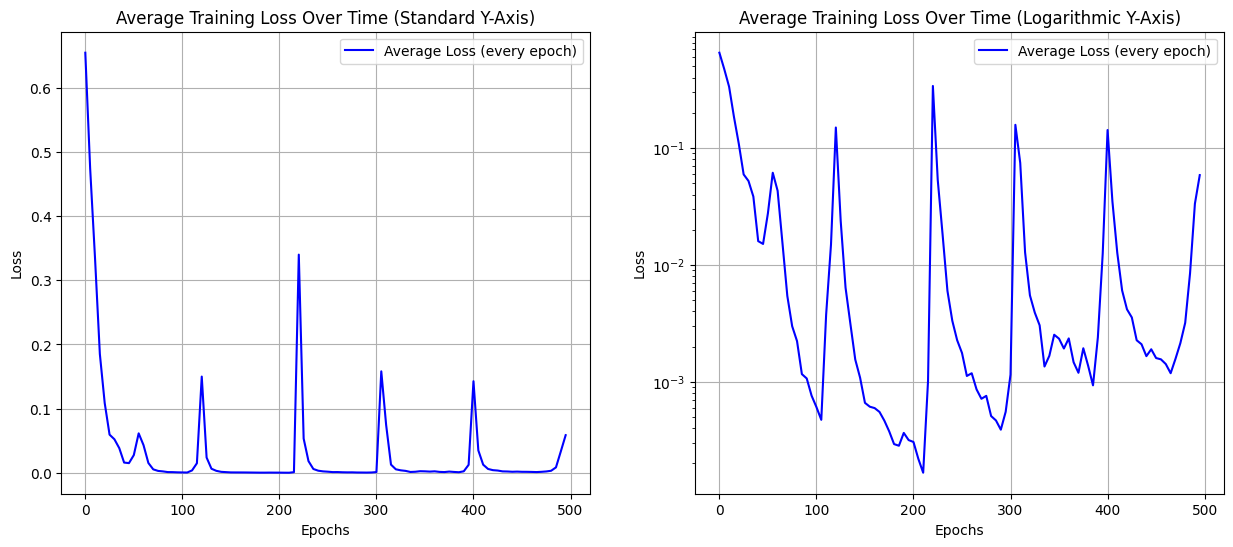

7min 21s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [29]:
model = LightningRiskCNNGRU().to(device)
%timeit -r 1 -n 1 train(dataloader = dataloader, model = model, num_epochs = 500, learning_rate = 1e-3)

In [38]:
def f1_accuracy(y_true: torch.Tensor,
                y_pred: torch.Tensor,
                threshold: float = 0.5,
                eps: float = 1e-8
               ) -> dict:
    
    # flatten
    y_true = y_true.reshape(-1)
    y_prob = y_pred.reshape(-1)
    # binarize
    y_pred_bin = (y_prob >= threshold).float()

    # true positives, false positives, false negatives, true negatives
    tp = (y_pred_bin * y_true).sum()
    fp = (y_pred_bin * (1 - y_true)).sum()
    fn = ((1 - y_pred_bin) * y_true).sum()
    tn = ((1 - y_pred_bin) * (1 - y_true)).sum()

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * (precision * recall) / (precision + recall + eps)
    accuracy  = (tp + tn) / (tp + fp + fn + tn + eps)

    return {
        'f1': f1.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'accuracy': accuracy.item()
    }

In [39]:
# Calculates accuracy, precision, recall, and f1

def evaluate_metrics(
    dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    device: torch.device = torch.device("cpu"),
    threshold: float = 0.5
) -> dict:

    model.eval()
    model.to(device)

    # accumulate all preds & targets
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs  = inputs.to(device)   # e.g. (B, T, C, H, W) or (B, T, F)
            targets = targets.to(device)  # (B, future_len)

            logits = model(inputs)        # (B, future_len), in [0,1]
            all_preds.append(logits)
            all_targets.append(targets)

    # concatenate along batch
    y_pred = torch.cat(all_preds, dim=0)    # (N, future_len)
    y_true = torch.cat(all_targets, dim=0)  # (N, future_len)

    # binarize for accuracy
    y_pred_bin = (y_pred >= threshold).float()

    # compute accuracy
    correct = (y_pred_bin == y_true).sum().item()
    total   = y_true.numel()
    accuracy = correct / total * 100.0

    # compute precision, recall, f1
    # reuse the f1_accuracy util from above
    metrics = f1_accuracy(y_true, y_pred, threshold=threshold)
    metrics['accuracy'] = accuracy

    print(
        f"Acc: {accuracy:.2f}%, "
        f"Prec: {metrics['precision']:.3f}, "
        f"Rec: {metrics['recall']:.3f}, "
        f"F1: {metrics['f1']:.3f}"
    )
    return metrics


In [40]:
# Assuming you have a test_dataloader prepared
validation_dataset = LightningDataset_Modified(data, pixel_coords, reject_zeros=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=True, generator=g)
accuracy = evaluate_metrics(validation_dataloader, model, device=device)

Acc: 65.87%, Prec: 0.126, Rec: 0.769, F1: 0.216


In [44]:
def extract_epoch(filename):
    match = re.search(r"_(\d+)\.pth$", filename)
    return int(match.group(1)) if match else -1

def evaluate_all_checkpoints(
    model_class,
    checkpoint_dir,
    train_loader,
    val_loader,
    device="cuda"
):
    model_paths   = sorted(
        glob.glob(f"./models/{checkpoint_dir}_*.pth"),
        key=extract_epoch
    )
    results       = []
    best_val_acc  = -1.0
    best_model_st = None

    for path in model_paths:
        epoch = extract_epoch(path)
        if epoch == -1:
            continue
        print(f"\nEvaluating model at epoch {epoch}…")

        # instantiate & load
        model = model_class().to(device)
        model.load_state_dict(torch.load(path, map_location=device))

        # get dicts of metrics
        train_metrics = evaluate_metrics(train_loader, model, device)
        val_metrics   = evaluate_metrics(val_loader,   model, device)

        # pull out the accuracy
        train_acc = train_metrics["accuracy"]
        val_acc   = val_metrics["accuracy"]

        print(f"Epoch {epoch}: Train Acc = {train_acc:.2f}% | Val Acc = {val_acc:.2f}%")
        results.append((epoch, train_acc, val_acc))

        # track best
        if val_acc > best_val_acc:
            best_val_acc  = val_acc
            best_model_st = model.state_dict()

    # save best
    if best_model_st is not None:
        best_path = f"./models/{checkpoint_dir}_best.pth"
        torch.save(best_model_st, best_path)
        print(f"\n✅ Best model saved to {best_path} with Val Acc = {best_val_acc:.2f}%")

    return results

In [45]:
def plot_accuracy_validation(results, save_path):
    # Unpack results
    epochs = [r[0] for r in results]
    train_accuracies = [r[1] for r in results]
    val_accuracies = [r[2] for r in results]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o', linestyle='-')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='x', linestyle='--')
    plt.title("Model Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Save to file
    plt.savefig(save_path)
    plt.show()
    print(f"Accuracy plot saved to {save_path}")


Evaluating model at epoch 0…


C:\Users\sunny\AppData\Local\Temp\ipykernel_27688\4201440009.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device)

Acc: 49.97%, Prec: 0.468, Rec: 0.394, F1: 0.428
Acc: 58.71%, Prec: 0.060, Rec: 0.394, F1: 0.105
Epoch 0: Train Acc = 49.97% | Val Acc = 58.71%

Evaluating model at epoch 20…
Acc: 77.63%, Prec: 0.830, Rec: 0.665, F1: 0.738
Acc: 69.81%, Prec: 0.126, Rec: 0.665, F1: 0.212
Epoch 20: Train Acc = 77.63% | Val Acc = 69.81%

Evaluating model at epoch 40…
Acc: 85.89%, Prec: 0.848, Rec: 0.855, F1: 0.852
Acc: 64.13%, Prec: 0.130, Rec: 0.855, F1: 0.226
Epoch 40: Train Acc = 85.89% | Val Acc = 64.13%

Evaluating model at epoch 60…
Acc: 66.53%, Prec: 0.688, Rec: 0.540, F1: 0.605
Acc: 67.98%, Prec: 0.101, Rec: 0.540, F1: 0.171
Epoch 60: Train Acc = 66.53% | Val Acc = 67.98%

Evaluating model at epoch 80…
Acc: 93.49%, Prec: 0.952, Rec: 0.909, F1: 0.930
Acc: 67.07%, Prec: 0.146, Rec: 0.909, F1: 0.252
Epoch 80: Train Acc = 93.49% | Val Acc = 67.07%

Evaluating model at epoch 100…
Acc: 100.00%, Prec: 1.000, Rec: 1.000, F1: 1.000
Acc: 69.06%, Prec: 0.165, Rec: 1.000, F1: 0.283
Epoch 100: Train Acc = 100.0

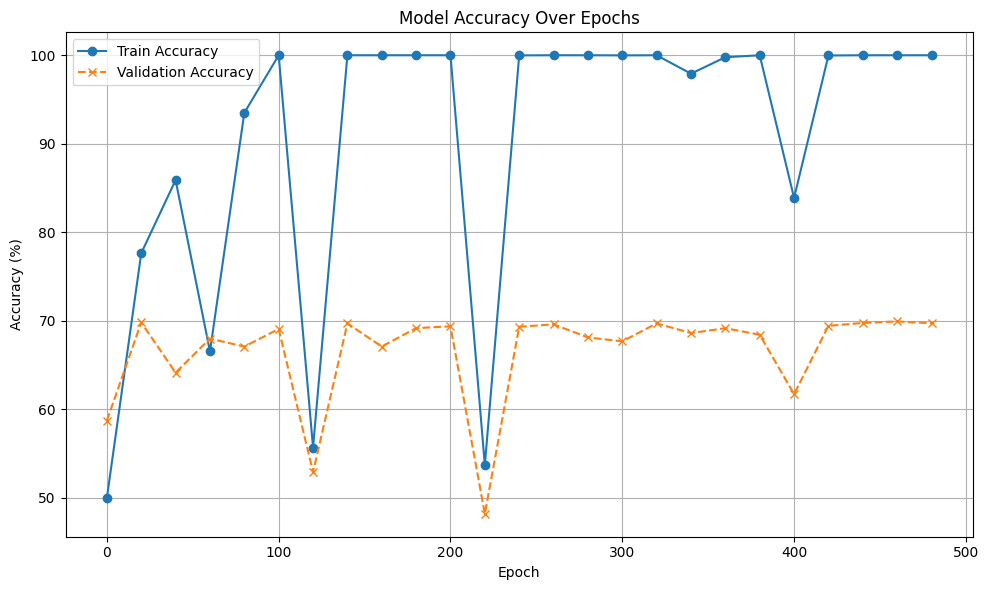

Accuracy plot saved to ./plots/model_2025_04_19_23_25.png


In [46]:
model_timestamp = "model_2025_04_19_23_25"

results = evaluate_all_checkpoints(
    model_class=LightningRiskCNNGRU,
    checkpoint_dir=model_timestamp,  # Folder with .pth files
    train_loader=dataloader,
    val_loader=validation_dataloader,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

plot_accuracy_validation(results,f"./plots/{model_timestamp}.png")

In [50]:
# Define the directory and base filename pattern
file_path_test = "../data/test_data/cleaned_compiled_data_normalized.csv"

# Load and concatenate all parts
test_data = pd.read_csv(file_path_test)

In [51]:
test_dataset = LightningDataset_Modified(test_data,pixel_coords,reject_zeros=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, generator=g)

In [54]:
import re, glob, torch
import matplotlib.pyplot as plt

def evaluate_and_plot_checkpoints(
    model_class,
    checkpoint_dir,
    train_loader,
    val_loader,
    test_loader,
    device="cuda"
):
    def extract_epoch(filename):
        match = re.search(r"_(\d+)\.pth$", filename)
        return int(match.group(1)) if match else -1

    model_paths = sorted(
        glob.glob(f"./models/{checkpoint_dir}_*.pth"),
        key=extract_epoch
    )
    results = []
    best_val_acc = -1.0
    best_test_acc = -1.0
    best_model_state = None

    for path in model_paths:
        epoch = extract_epoch(path)
        if epoch == -1:
            continue

        print(f"\n🔍 Evaluating model at epoch {epoch}...")

        # load model
        model = model_class().to(device)
        model.load_state_dict(torch.load(path, map_location=device))

        # get full metrics dicts
        train_metrics = evaluate_metrics(train_loader, model, device)
        val_metrics   = evaluate_metrics(val_loader,   model, device)
        test_metrics  = evaluate_metrics(test_loader,  model, device)

        # extract the float accuracies
        train_acc = train_metrics["accuracy"]
        val_acc   = val_metrics["accuracy"]
        test_acc  = test_metrics["accuracy"]

        print(
            f"Epoch {epoch}: "
            f"Train Acc = {train_acc:.2f}% | "
            f"Val Acc   = {val_acc:.2f}% | "
            f"Test Acc  = {test_acc:.2f}%"
        )

        results.append((epoch, train_acc, val_acc, test_acc))

        # track best
        if val_acc > best_val_acc:
            best_val_acc   = val_acc
            best_test_acc  = test_acc
            best_model_state = model.state_dict()

    # save best
    if best_model_state is not None:
        best_model_path = f"./models/{checkpoint_dir}_best.pth"
        torch.save(best_model_state, best_model_path)
        print(f"\n✅ Best model saved to {best_model_path} with Val Acc = {best_val_acc:.2f}%")

        # also write out test acc
        txt = (
            f"Best Validation Accuracy: {best_val_acc:.2f}%\n"
            f"Test Accuracy at Best Val: {best_test_acc:.2f}%\n"
        )
        with open(f"./models/{checkpoint_dir}_best_test.txt", "w") as f:
            f.write(txt)
        print(f"✅ Test accuracy saved to ./models/{checkpoint_dir}_best_test.txt")

    # plotting
    if results:
        epochs, tr_accs, vl_accs, ts_accs = zip(*results)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, tr_accs, label="Train", marker='o')
        plt.plot(epochs, vl_accs, label="Val",   marker='x', linestyle='--')
        plt.plot(epochs, ts_accs, label="Test",  marker='s', linestyle=':')
        plt.title("Accuracy over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        plot_path = f"./models/{checkpoint_dir}_accuracy_plot.png"
        plt.savefig(plot_path)
        plt.show()
        print(f"📊 Plot saved to {plot_path}")

    return results



🔍 Evaluating model at epoch 0...


C:\Users\sunny\AppData\Local\Temp\ipykernel_27688\1606204548.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device)

Acc: 49.97%, Prec: 0.468, Rec: 0.394, F1: 0.428
Acc: 58.71%, Prec: 0.060, Rec: 0.394, F1: 0.105
Acc: 58.11%, Prec: 0.064, Rec: 0.366, F1: 0.109
Epoch 0: Train Acc = 49.97% | Val Acc   = 58.71% | Test Acc  = 58.11%

🔍 Evaluating model at epoch 20...
Acc: 77.63%, Prec: 0.830, Rec: 0.665, F1: 0.738
Acc: 69.81%, Prec: 0.126, Rec: 0.665, F1: 0.212
Acc: 61.37%, Prec: 0.107, Rec: 0.610, F1: 0.182
Epoch 20: Train Acc = 77.63% | Val Acc   = 69.81% | Test Acc  = 61.37%

🔍 Evaluating model at epoch 40...
Acc: 85.89%, Prec: 0.848, Rec: 0.855, F1: 0.852
Acc: 64.13%, Prec: 0.130, Rec: 0.855, F1: 0.226
Acc: 62.66%, Prec: 0.107, Rec: 0.585, F1: 0.181
Epoch 40: Train Acc = 85.89% | Val Acc   = 64.13% | Test Acc  = 62.66%

🔍 Evaluating model at epoch 60...
Acc: 66.53%, Prec: 0.688, Rec: 0.540, F1: 0.605
Acc: 67.98%, Prec: 0.101, Rec: 0.540, F1: 0.171
Acc: 64.38%, Prec: 0.091, Rec: 0.451, F1: 0.151
Epoch 60: Train Acc = 66.53% | Val Acc   = 67.98% | Test Acc  = 64.38%

🔍 Evaluating model at epoch 80...
A

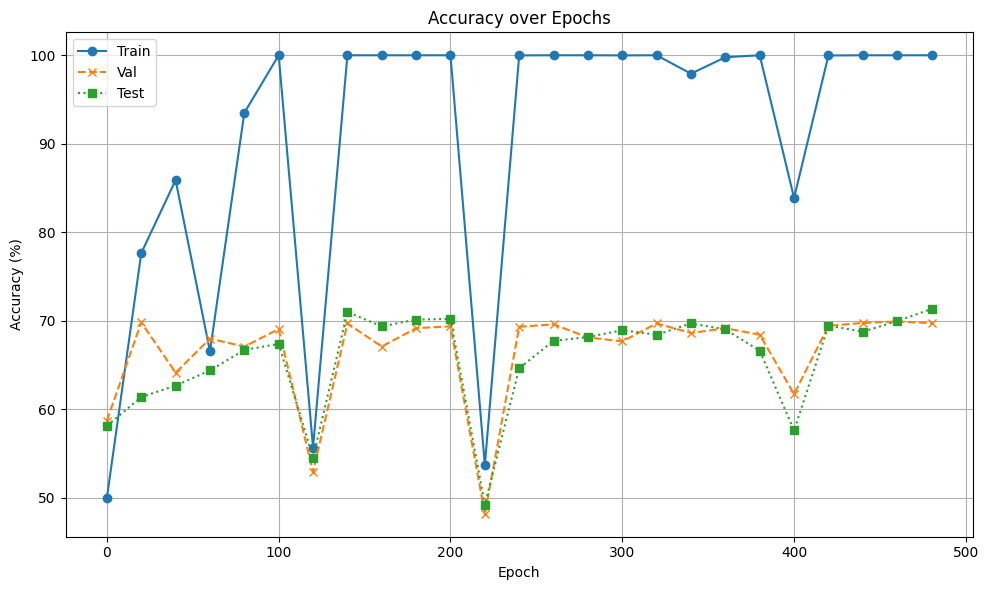

📊 Plot saved to ./models/model_2025_04_19_23_25_accuracy_plot.png


In [55]:
#Experimental

model_timestamp = "model_2025_04_19_23_25"

results = evaluate_and_plot_checkpoints(
    model_class=LightningRiskCNNGRU,
    checkpoint_dir=model_timestamp,  # Folder with .pth files
    train_loader=dataloader,
    val_loader=validation_dataloader,test_loader = test_dataloader,
    device="cuda" if torch.cuda.is_available() else "cpu"
)